## Project 3: Numerical Methods for Differential Equations

## Task 1

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import diags
from scipy.sparse import identity
from scipy.linalg import toeplitz
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import eigs
from mpl_toolkits.mplot3d import axes3d

In [63]:
def toeplitz_like(dim):
    return csr_matrix((diags([1, -2, 1], [-1, 0, 1], shape=(dim, dim))) * (dim + 1)**2)

def euler_step(A: np.array, y_n: np.array, h: float, alpha, beta):
    return np.concatenate(([alpha], y_n + h * A @ y_n.T, [beta]))

## Task 1.1

In [64]:
def euler_solve(g_0, N, M, t_end, alpha, beta):
    xx = np.linspace(0, 1, N+2)
    tt = np.linspace(0, t_end, M+1)
    Y = np.zeros((M+1, N+2))
    Y[0,:] = g_0(xx)
    toep = toeplitz_like(N)
    for i in range(M):
        Y[i+1,:] = euler_step(toep, Y[i,:][1:-1], t_end/M, alpha, beta)
    return Y, tt, xx

In [65]:
def plot3d(Y, Xgrid, tgrid):
     T, X = np.meshgrid(np.transpose(tgrid), Xgrid)

     fig = plt.figure(figsize=(10, 10))
     ax = fig.add_subplot(111, projection='3d')
     ax.plot_surface(T, X, np.transpose(Y))

     ax.set_xlabel('Time')
     ax.set_ylabel('Space')
     ax.set_zlabel('Value')
     ax.set_title('Approximation of Solutions to the Diffusion Equation \n with initial value'+
                                    r'$u(0,x)=x(1-x)^2$')
     
     plt.show()

## Test Task 1.1

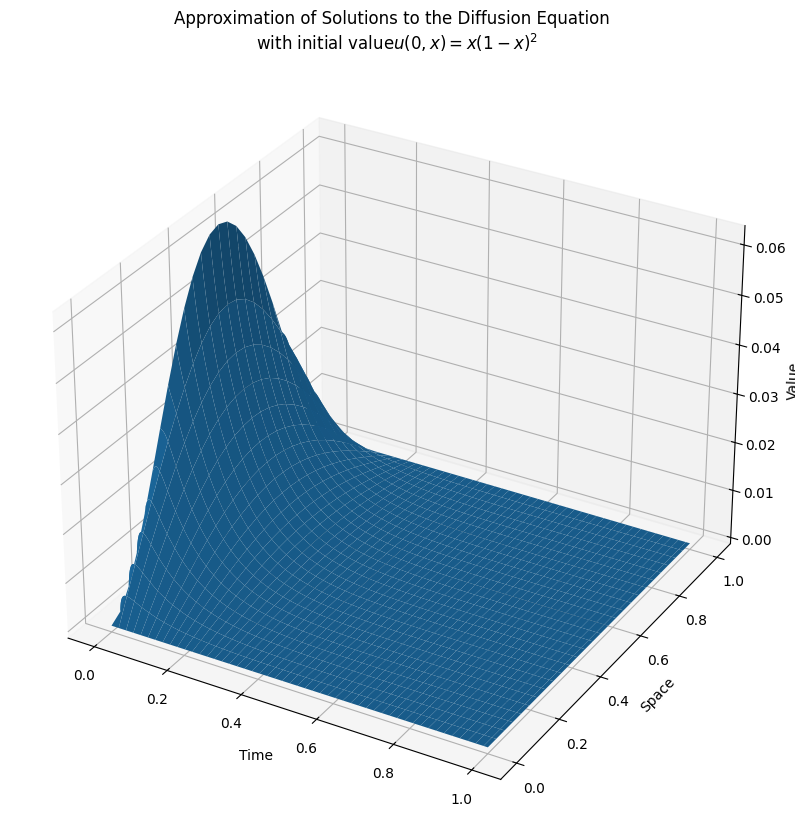

In [66]:
N = 25
M = 2*51**2
t_end = 1
alpha = 0
beta = 0

Y, t_grid, x_grid = euler_solve(lambda x : (x*(1-x))**2, N, M, t_end, alpha, beta)
plot3d(Y, x_grid, t_grid)

##  Experimental Determination of CFL condition

Below, a series of approximation are done for different values of the CFL constant $\mu=\frac{\Delta t}{\Delta x^2}$ to determine for which values the explicit Euler method converges.

In [67]:
def test_conv(mu, values, convergence):
    N = 25
    M = int(((N+1)**2)/mu)
    t_end = 1
    alpha = 0
    beta = 0
    Y, t_grid, x_grid = euler_solve(lambda x : (x*(1-x))**2, N, M, t_end, alpha, beta)
    
    if(np.sum(abs(Y[-1,:]))<0.001):
        values.append(f"CFL={mu}")
        convergence.append("Converges")
    else:
        values.append(f"CFL={mu}")
        convergence.append("Diverges")


In [68]:
values = []
convergence = []

for k in range(10):
    mu = (k+1) / 10 
    test_conv(mu, values, convergence)
    
df = pd.DataFrame({
    "values": values,
    "convergence": convergence,
    })

df.style \
.format(precision=3, thousands=".", decimal=",") \
.format_index(str.upper, axis=1)
display(df)

C:\Users\filip\AppData\Local\Temp\ipykernel_12016\4162189152.py:5: RuntimeWarning: invalid value encountered in add
  return np.concatenate(([alpha], y_n + h * A @ y_n.T, [beta]))


ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

From the above broad testing, we can determine that the line of convergence is in the intervall $\mu\in[5,6)$.

In [69]:
values = []
convergence = []

testcases = [num/100 for num in range(50, 60)]
for test in testcases:
    test_conv(test, values, convergence)

df = pd.DataFrame({
    "values": values,
    "convergence": convergence,
    })

df.style \
.format(precision=3, thousands=".", decimal=",") \
.format_index(str.upper, axis=1)
display(df)

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

The inteval is now narrowed down to $\mu\in[0.5,0.51)$ and further experiments are conducted

In [70]:
def conv(mu):
    N = 25
    M = int(((N+1)**2)/mu)
    t_end = 1
    alpha = 0
    beta = 0
    Y, t_grid, x_grid = euler_solve(lambda x : (x*(1-x))**2, N, M, t_end, alpha, beta)
    if(np.sum(abs(Y[-1,:]))<0.00005):
        return True
    else:
        return False
    
mu = 0.505
while(not conv(mu)):
    mu -= (mu - 0.5)/2
print(mu)

0.50125


With a tolerance of $0.00005$, the first value of convergence is $\mu = 0.50125$ and for smaller values, the code takes too long to run without further optimization which leaves the experimenta result och the maximal CFL condition in the interval $\mu\in[0.5, 0.50125)$ which is very close to the theoretical value of $\frac{1}{2}$.

Visualisation of divirging solution:

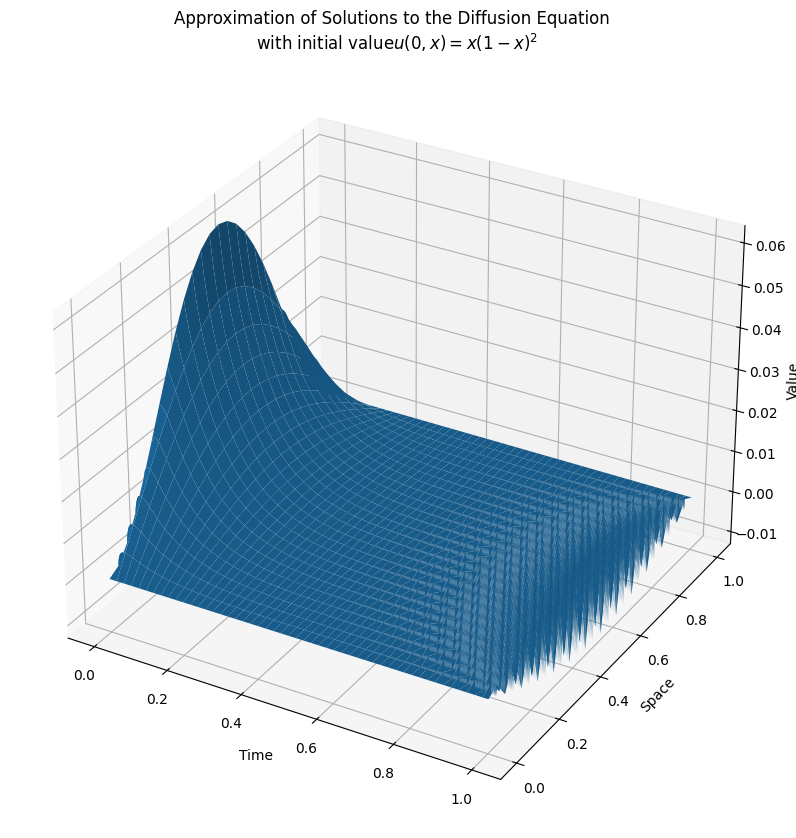

In [71]:
mu = 0.503
N = 25
M = int(((N+1)**2)/mu)
t_end = 1
alpha = 0
beta = 0
Y, t_grid, x_grid = euler_solve(lambda x : (x*(1-x))**2, N, M, t_end, alpha, beta)
plot3d(Y, x_grid, t_grid)

## Task 1.2

\begin{equation*}
    u^{n+1}=u^n+\frac{1}{2}\Delta t\left(T_{\Delta x}u^n+T_{\Delta x}u^{n+1}\right)
\end{equation*}

\begin{equation*}
    u^{n+1}=\left(I-\frac{\Delta t}{2}T_{\Delta x}\right)^{-1}\left(I+\frac{\Delta t}{2}T_{\Delta x}\right)u^n
\end{equation*}

In [72]:
def Crank_Nicholson_step(Tdx, uold, dt, alpha, beta):
    I = identity(Tdx.get_shape()[0])
    RHS = I-0.5*dt*Tdx
    LHS = (I+0.5*dt*Tdx) @ (uold.T)
    return np.concatenate(([alpha], spsolve(RHS, LHS), [beta]))
        
def Crank_Nicholson_solver(g_0, N, M, t_end, alpha, beta):
    xx = np.linspace(0, 1, N+2)
    tt = np.linspace(0, t_end, M+1)
    Y = np.zeros((M+1, N+2))
    Y[0,:] = g_0(xx)
    toep = toeplitz_like(N)
    for i in range(M):
        Y[i+1,:] = Crank_Nicholson_step(toep, Y[i,:][1:-1], t_end/M, alpha, beta)
    return Y, tt, xx

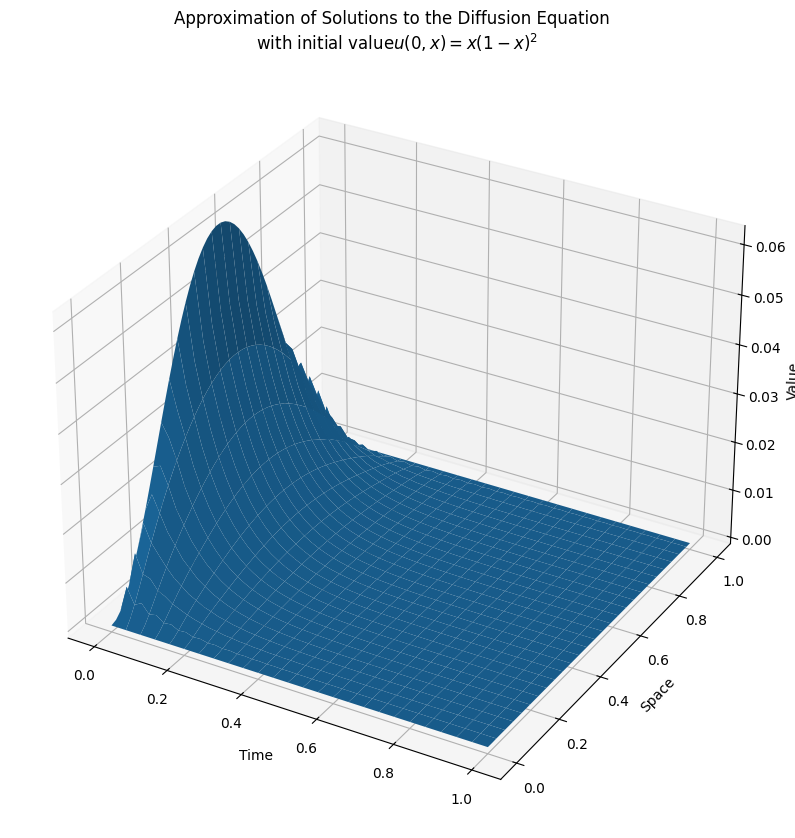

In [73]:
N = 50
M = 50
t_end = 1
alpha = 0
beta = 0
Y, t_grid, x_grid = Crank_Nicholson_solver(lambda x : (x*(1-x))**2, N, M, t_end, alpha, beta)
plot3d(Y, x_grid, t_grid)

# Part 2

\begin{equation*}
    \begin{cases}
        u_t = au_x\\
        u(t,0)=u(t,1), \forall t\\
        u(0,x)=g(x)
    \end{cases}
\end{equation*}
$\Delta x = \frac{1}{N}$, $N$ evaluation points, $x_1=0, x_{N+1}=1$ and $u_{N+1}=u_1$. $g(0)=g(1)$ and $g'(0)=g'(1)$

Lax-Wendroff scheme:
\begin{equation*}
    \begin{cases}
        u_j^{n+1}=\frac{a\mu}{2}(1+a\mu)_{j-1}^n+(1-a^2\mu^2)u_j^n+\frac{a\mu}{2}(a\mu-1)u_{j+1}^n\\
        \mu=\frac{\Delta t}{\Delta x}
    \end{cases}
\end{equation*}

In [74]:
def LaxWen_Toeplitz(amu, N):
     A = toeplitz([1-(amu)**2, (amu)/2*(1+amu)] + [0] * (N-1), [1-(amu)**2, -(amu)/2*(1-amu)] + [0] * (N-1)) 
     A[-1,0] = amu/2*(amu-1)
     A[0,-1] = amu/2*(amu+1)
     return csr_matrix(A)

def LaxWen_step(u_old, A):
     return A @ np.transpose(u_old)

def LaxWen_solver(g0, t_end, N, M, a):
     dt = t_end/M
     dx = 1/N
     amu = a*dt/dx

     xx = np.linspace(0, 1, N+1)
     tt = np.linspace(0, t_end, M+1)
     Y = np.zeros((M+1, N+1))
     Y[0,:] = g0(xx)
     A = LaxWen_Toeplitz(amu, N)
     for i in range(M):
        Y[i+1,:][:N+1] = LaxWen_step(Y[i,:][:N+1], A)
     Y[:,-1] = Y[:,0]
     return Y, tt, xx 

def plot3d(Y, Xgrid, tgrid):
     T, X = np.meshgrid(np.transpose(tgrid), Xgrid)

     fig = plt.figure(figsize=(10, 10))
     ax = fig.add_subplot(111, projection='3d')
     ax.plot_surface(T, X, np.transpose(Y))

     ax.set_xlabel('Time')
     ax.set_ylabel('Space')
     ax.set_zlabel('Value')
     ax.set_title('Approximation of Solutions to the Advection Equation \n with initial value '+
                                    r'$u(0,x)=e^{-100(x-0.5)^2}$')
     
     plt.show()

1001


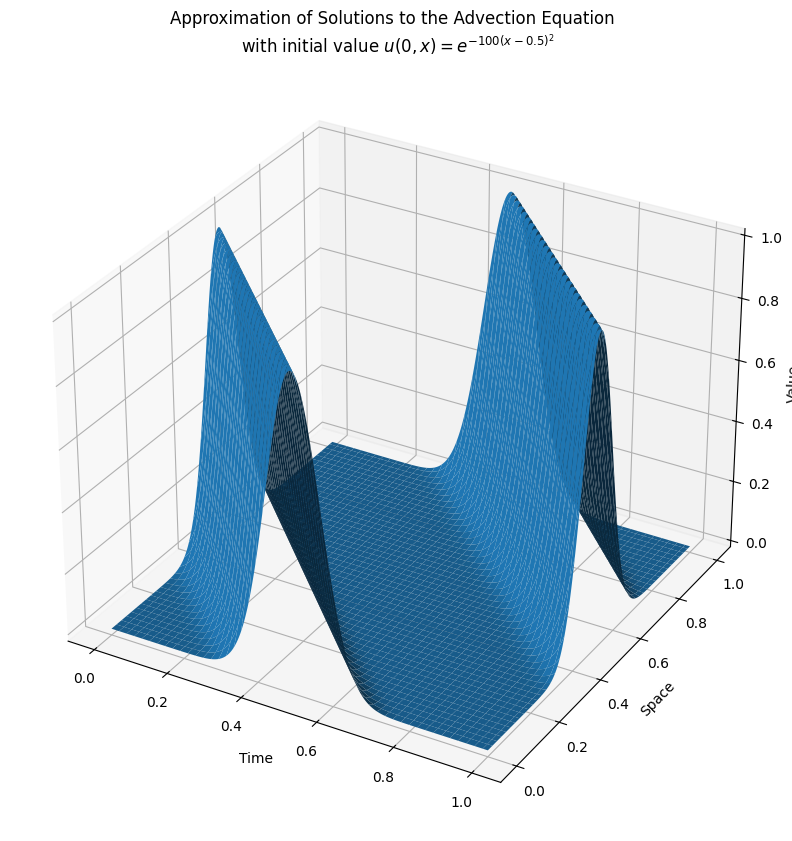

In [105]:
def pulse(x):
    return np.exp(-100*(x-0.5)**2)

Y, tt, xx = LaxWen_solver(pulse, 1, 1000, 1000, -1)
plot3d(Y, xx, tt)

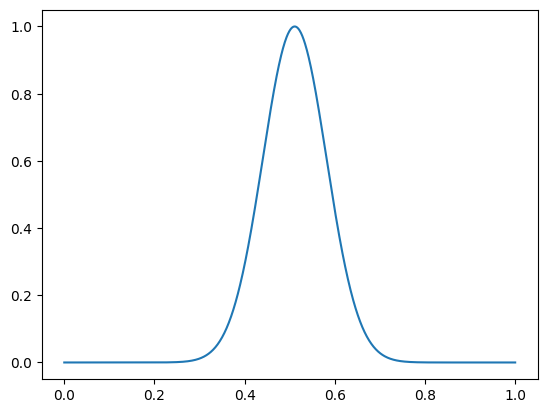

In [111]:
import time
import pylab as pl
from IPython.display import display, clear_output

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

for i in range(100):
    ax.cla()
    ax.plot(xx, Y[10*i,:])
    display(fig)
    
    clear_output(wait = True)
    plt.pause(0.00000001)

## CFL = 0.9
$CFL = a\frac{\Delta t}{\Delta x}= a\frac{\frac{t_f}{M}}{\frac{1}{N}}= a\frac{t_fN}{M}$

1001


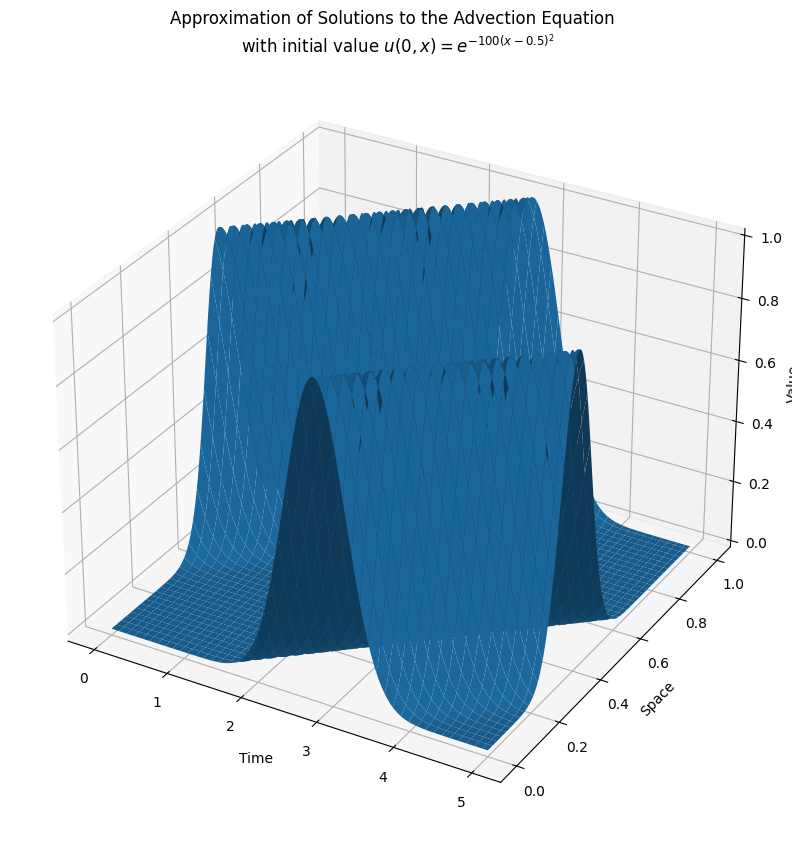

In [125]:
tf = 5
M = 1000
N = 1000
a = 0.9*M/tf/N
Y, tt, xx = LaxWen_solver(pulse, tf, N, M, a)
plot3d(Y, xx, tt)

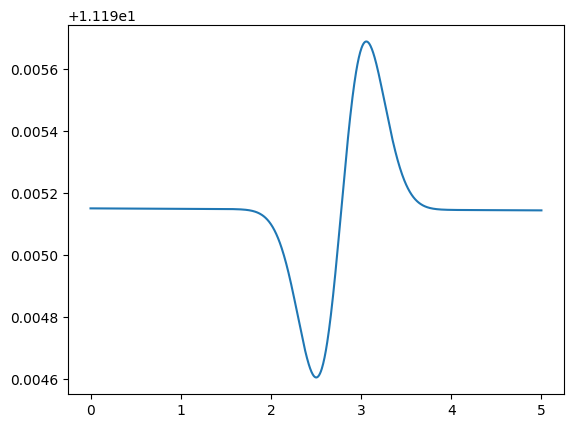

In [126]:
norm = np.zeros(M+1)

for i in range(M+1):
    norm[i] = np.linalg.norm(Y[i,:])

plt.plot(tt, norm)

## CFL = 1

1001


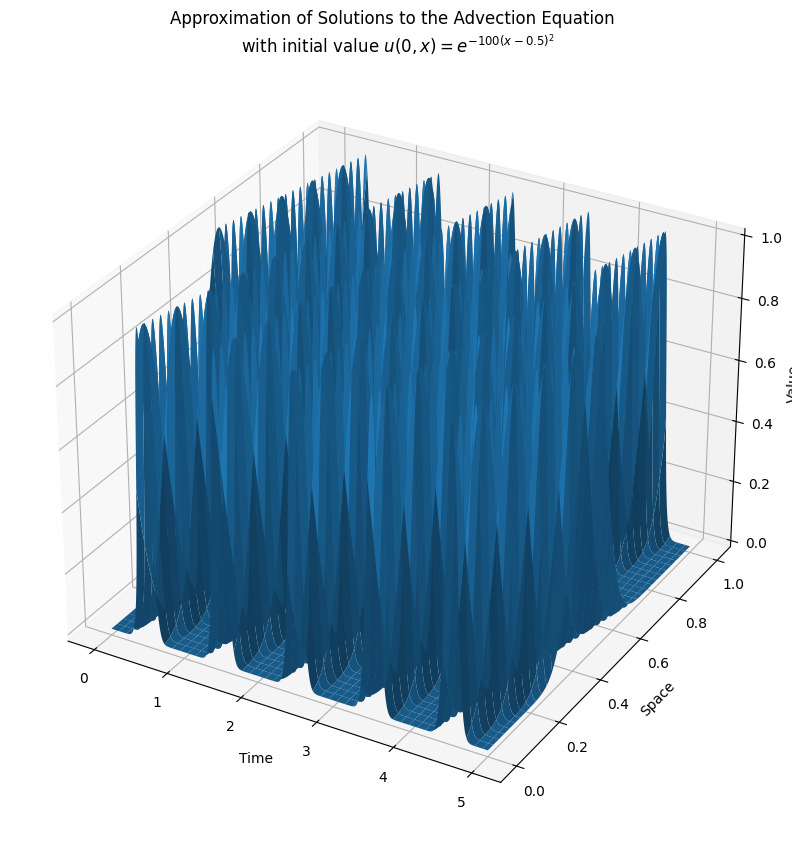

In [129]:
tf = 5
M = 1000
N = int(M/tf)
a = M/tf/N
Y, tt, xx = LaxWen_solver(pulse, tf, N, M, a)
plot3d(Y, xx, tt)

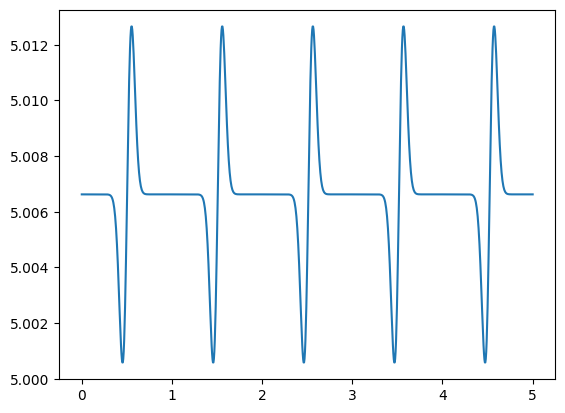

In [130]:
norm = np.zeros(M+1)

for i in range(M+1):
    norm[i] = np.linalg.norm(Y[i,:])

plt.plot(tt, norm)